# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Цель проекта

Целью данного проекта является решение задачи прогнозирования оттока клинтов. А именно: построение модели, которая по данным признакам сможет предсказывать уйдет клиент или нет. Качество модели оценивается метрикой ROC-AUC, которая должна быть не менее 0,85 на тестовой выборке.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных
Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Подготовка данных

In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.pipeline import FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
RANDOM_STATE = 220523

### Загрузка и знакомство с данными

In [3]:
# импорты для ревьюера
data_contract = pd.read_csv('/datasets/contract_new.csv')
data_phone = pd.read_csv('/datasets/phone_new.csv')
data_internet = pd.read_csv('/datasets/internet_new.csv')
data_personal = pd.read_csv('/datasets/personal_new.csv')

data_contract = pd.read_csv('contract_new.csv')
data_phone = pd.read_csv('phone_new.csv')
data_internet = pd.read_csv('internet_new.csv')
data_personal = pd.read_csv('personal_new.csv')

### Информация о договоре

In [4]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Приведем название столбцов к змеиному регистру

In [5]:
data_contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges']

In [6]:
data_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
data_contract.describe()

,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [8]:
data_contract['payment_method'].sort_values().unique()

array(['Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'], dtype=object)

In [9]:
data_contract['type'].sort_values().unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [10]:
data_contract.duplicated().sum()

0

Приведем тип данных в столбце 'begin_date' к формату даты и времени datetime. 

In [11]:
data_contract['begin_date'] = pd.to_datetime(
    data_contract['begin_date'], format='%Y-%m-%d')

В колонке total_charges тип данных object, но на самом деле здесь содержаться суммы выплат, поэтому приведем тип даннных в этой колонке к float. Но для начала выясним, почему данные записаны строками

In [12]:
data_contract['total_charges'].sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

Заметим, что в столбце total_charges присутсвуют пустые строки ' '

In [13]:
data_contract[data_contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [14]:
data_contract[data_contract['total_charges'] == ' ']['total_charges'].count()

11

Получаем, что таких строк с пропусками всего 11, также все эти строки принадлежат классу новых пользователей. Заметим, что информации по полной оплате новых пользователей еще просто нет, посколльку данные собраны в день регистрации этих пользователей 2020-02-02, а значит эти данные неинформативны и мы можем просто удалить эти строки.

In [15]:
data_contract = data_contract[data_contract['total_charges'] != ' ']

In [16]:
data_contract['total_charges'].sort_values().unique()

array(['100.17', '100.19', '100.2', ..., '998.89', '999.6', '999.9'],
      dtype=object)

Приведем значения в total_charges численному типу

In [17]:
data_contract['total_charges'] = data_contract['total_charges'].astype('float')

Целевым признаком в задаче классификации будет столбец end_date, поскольку именно в нем содержится информация об актуальных и ушедших польозвателях. Но можем заметить, что в этом столбце есть два типа значений: "No" значит актуальный пользователь, а дата - это дата окончания договора. Создадим новый столбец 'is_active', который будет нашим целевым признаком и будет отвечать на вопрос активен пользователь или нет.

In [18]:
data_contract['end_date'].value_counts()

No            5931
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-10-01       1
2014-11-01       1
2014-06-01       1
Name: end_date, Length: 67, dtype: int64

In [19]:
data_contract['is_active'] = data_contract['end_date'].apply ( lambda x: 1 if x == 'No' else 0)

In [20]:
data_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,is_active
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,1
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,1


In [21]:
data_contract['is_active'].value_counts()

1    5931
0    1101
Name: is_active, dtype: int64

In [22]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   is_active          7032 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 549.4+ KB


Посмотрим на соотношение ушедших и действующих пользователей.

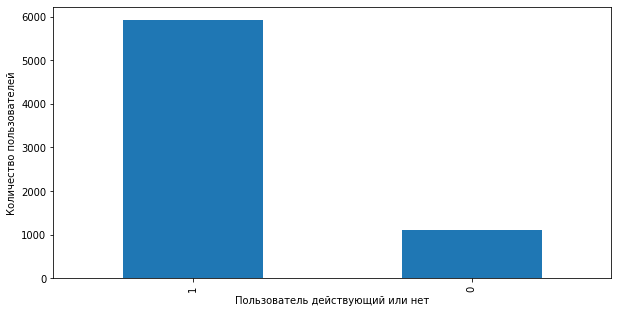

In [23]:
data_contract['is_active'].value_counts(
).plot.bar(figsize=(10,5), xlabel='Пользователь действующий или нет', ylabel='Количество пользователей');

Можем заметить, что количество активных пользователей составляет 84% от всех пользователей, а ушедших всего 16%. Перед нами явный дисбаланс классов, с которым предстоит поработать далее.

### Информация об услугах телефонии

In [24]:
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [25]:
data_phone.columns = ['customer_id', 'multiple_lines']

In [26]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [27]:
data_phone.duplicated().sum()

0

### Информация об интернет-услугах

In [28]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [29]:
data_internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup', 
                         'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [30]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [31]:
data_internet.duplicated().sum()

0

### Персональные данные клиента

In [32]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [33]:
data_personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 
                         'dependents']

In [34]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [35]:
data_personal.duplicated().sum()

0

Перед нами четыре таблицы, с помощью которых нам предстоит решить задачу классификации, то есть предскать какие клиенты могут уйти, а какие остаться. Основные этапы решения задачи следующие:

1. Подготовка данных. 
    На этом этапе ознакомимся с данными в таблицах. Можем заметить, что во всех таблицах отсутсвуют явные пропуски в данных и дубликаты строк. На этом этаме следует изучить таблицы, избавиться от пропусков и дубликатов, определить целевой признак.

2. Анализ данных. 
    Здесь уже можно подробнее изучить данные, обьеденить таблицы, избавиться от неинформативных столбцов, добавить новые признаки и посмотреть на распределения количественных величин, соотношение классов целевого признака, посмотреть на корреляцию признаков.

3. Предобратока данных.
    Здесь нам следует разделить данные на обучающую и тестовые выборки, при этом учесть возможность дисбаланса классов.

4. Построение модели.
    На этом этапе предстоит разработать несколько моделей машинного обучения для предсказания, а также выбрать модель с наилучшим показателем метрики на валидационных данных.

5. Тестирование модели.
    На этапе тестирования проверяем какую метрику дает наилучшая модель.

Вопросы:

1) Для задачи классификаци в качестве метрики будем использовать ROC-AUC, так как видим явный дисбаланс классов. Какого значения метрики следует достичь, чтобы точность модели удовлетворяла заказчика?
2) Есть ли какой-то лимит по времени обучения модели и ее работе?
3) Какие основные формы отчета заказчик ожидает увидеть?

## Анализ данных

Обьеденим четыре датасета в один. Отметим, что персональные id каждого клиента содержатся только в таблице data_contract, и нам нельзя их потерять, а значит присоеденим остальные таблицы к data_contract.

In [36]:
data_full = data_contract.merge(data_phone, on='customer_id', how='left')
data_full = data_full.merge(data_internet, on='customer_id', how='left')
data_full = data_full.merge(data_personal, on='customer_id', how='left')

In [37]:
data_full.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,is_active,multiple_lines,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,1,NaN,...,No,Yes,No,No,No,No,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,1,No,...,Yes,No,Yes,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,1,No,...,Yes,Yes,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1,NaN,...,Yes,No,Yes,Yes,No,No,Male,0,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,1,No,...,No,No,No,No,No,No,Female,0,No,No


### Обработка пропусков

Заметим, что в столбцах таблиц data_internet и data_phone появились пропуски. Эти пропуски обусловлены тем, что не все клиенты, пользующиеся услугами телефонии являются клиентами интернет сервиса и наоборот. Заполним эти пропуски значениями No, и создадим новый признак is_internet, который будет отвечать на вопрос, пользуется ли клиент интернет услагми. Таким образом, клиенты делятся на два типа, те кто пользуются только услугами телефонии и на тех, кто пользуется услугами телефонии и интернета либо только интернета. Также создадим столбец is_phone, чтобы аналагичным образом разделить клиентов на тех, кто пользуется только услагами интернета и остальных. Создание новых признаков необходимо,  чтобы получить корректную картину о пользователях.

In [38]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   is_active          7032 non-null   int64         
 9   multiple_lines     6352 non-null   object        
 10  internet_service   5512 non-null   object        
 11  online_security    5512 non-null   object        
 12  online_backup      5512 non-null   object        
 13  device_protection  5512 non-null   object        
 14  tech_sup

In [39]:
data_full['is_internet'] = data_full['online_security'].replace(['No', 'Yes'], 1).fillna(0)
data_full['is_phone'] = data_full['multiple_lines'].replace(['No', 'Yes'], 1).fillna(0)

In [40]:
data_full[['internet_service', 'multiple_lines', 
           'online_security', 'online_backup', 
           'device_protection','tech_support',  'streaming_tv',
          'streaming_movies']] = data_full[['internet_service', 'multiple_lines', 
           'online_security', 'online_backup', 
           'device_protection','tech_support',  'streaming_tv',
          'streaming_movies']].fillna('No')

In [41]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   is_active          7032 non-null   int64         
 9   multiple_lines     7032 non-null   object        
 10  internet_service   7032 non-null   object        
 11  online_security    7032 non-null   object        
 12  online_backup      7032 non-null   object        
 13  device_protection  7032 non-null   object        
 14  tech_sup

По общей таблице можно увидеть, что в столбце 'end_date' содержатся даты ухода клиента, либо информация о том, что клиент актуален. Также известно, что данные собирались на момент 1 февраля 2020 года, заменим значения 'No' для актуальных клиентов на дату сбора информации, чтобы определить период жизни клиента и посмотреть, как уходили клиенты со временем.

In [42]:
data_full['end_date'] = data_full['end_date'].replace('No', '2020-02-01')

In [43]:
data_full['end_date'] = pd.to_datetime(
    data_full['end_date'], format='%Y-%m-%d')

Создаем новый столбец 'period' - время (дни), которое клиент пользовался или пользуется услагами компании.

In [44]:
data_full['period'] = (data_full['end_date'] - data_full['begin_date']).dt.days

### Диаграммы размаха

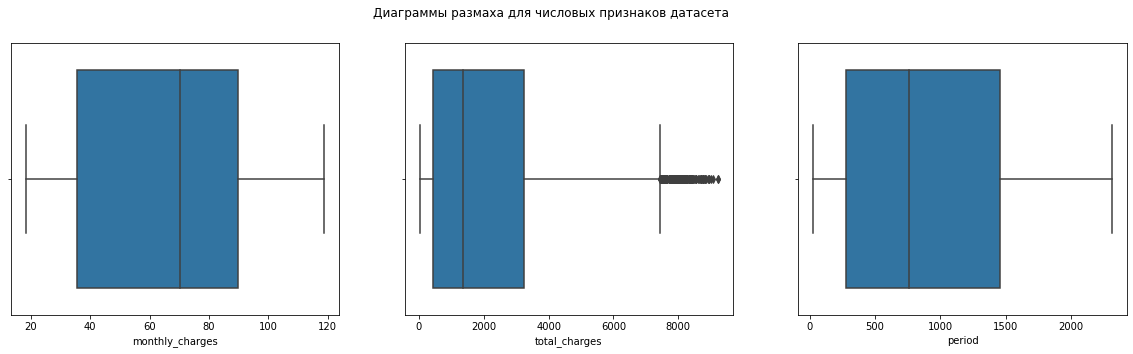

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
sns.boxplot(x=data_full['monthly_charges'], ax=ax1)
sns.boxplot(x=data_full['total_charges'], ax=ax2)
sns.boxplot(x=data_full['period'], ax=ax3)
fig.suptitle('Диаграммы размаха для числовых признаков датасета');

На диаграмме размаха для ежемесячных выплат можем заметить, что выбросов нет, медиана равна 70.35. Медиана в столбце общих трат равна 1345.275, также заметим, что в этом столбце есть аномально большое количество трат (больше 1461) - это выбросы. Для значений периода активности клиента медиана составляет 761 день, выбросов в этом столбце нет.

In [46]:
data_full[['monthly_charges', 'total_charges','period']].describe()

,monthly_charges,total_charges,period
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,899.961320
std,30.085974,2112.736199,682.738777
min,18.250000,19.050000,28.000000
25%,35.587500,439.745000,276.000000
50%,70.350000,1345.275000,761.000000
75%,89.862500,3239.317500,1461.000000
max,118.750000,9221.380000,2314.000000


### Распределения клиентов

Посмотрим на график распределения количества ушедших клиентов, а также на рост клиентов во времени. На графике роста клиентов заметим два локальных максимума в начале 2014 и середине 2019 годов, в остальное время прирост новых клиентов был постоянным в районе 350 клиентов в 4.5 месяца. Такие всплески роста могут быть связаны с проведенными пиар-компаниями и тд. Из графика по количеству ушедших клиентов видно, что число актуальных клиентов падает с каждым годом при равномерном приросте пользователей с 2015-2019 года, а значит действительно есть смысл в разработке стратегии по удержанию клиентов.

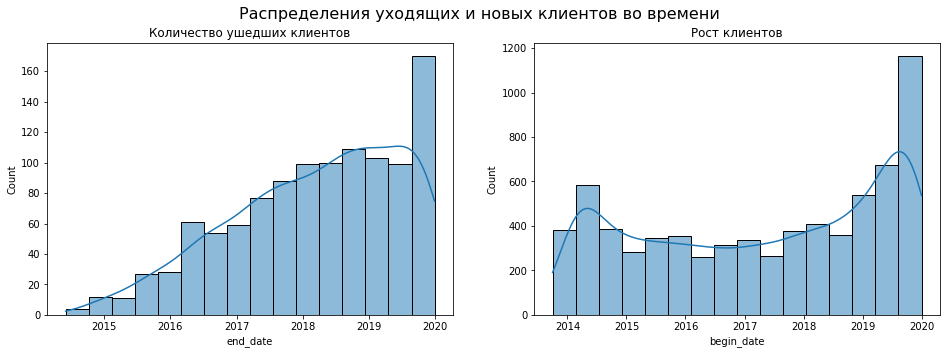

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.histplot(data_full[data_full['is_active'] == 0]['end_date'], 
             ax=ax1, kde = True).set(title = 'Количество ушедших клиентов')
sns.histplot(data_full['begin_date'], ax=ax2, kde = True).set(title = 'Рост клиентов')
fig.suptitle('Распределения уходящих и новых клиентов во времени', fontsize=16);

На данном графике представлены распределения количества клиентов в зависимости от времени жизни клиента. На графике распрделения для актуальных пользователей можно увидеть два пика: в районе от 0 до 500 дней и в районе 2000 дней. Эти пики говорят о том, что актуальные пользователи делятся условно на три группы: новые клиенты (от 0 до 500 дней), надежные клиенты (от 500 до 2000) и преданные клиенты компании (более 2000 дней). Из второго графика распределения ушедших клиентов можем заметить, что новых клиентов много, но также новые клиенты с периодом пользования от 0 до 1000 дней быстрее уходят. Пик периода жизни уходящего клиента приходится на 1000 дней, а далее клиенты уходят с меньшей регулярностью. Таким образом, можно сделать вывод о том, что самый опасный период, в который следует принять меры, чтобы клиент не ушел, приходится на диапазон от 0 до 1000 дней.

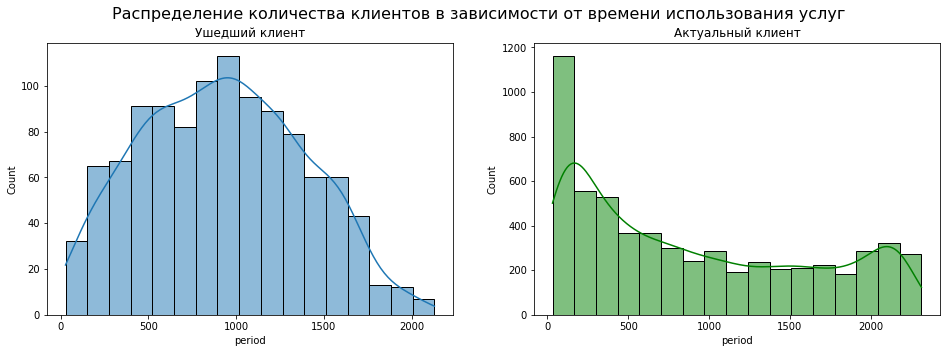

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.histplot(data_full[data_full['is_active'] == 0]['period'],
             ax = ax1, kde=True ).set_title('Ушедший клиент')
sns.histplot(data_full[data_full['is_active'] == 1]['period'], 
             ax = ax2, kde=True, color='green').set_title('Актуальный клиент')
fig.suptitle('Распределение количества клиентов в зависимости от времени использования услуг', fontsize=16);

Построим график распределения количества клиентов в зависимости от ежемесячных выплат. На обоих графиках, дя ушедших и актуальных клиентов, можем заметить несколько групп. Есть большое количество пользователей, которые платят ежемясчные платежи в интервале от 20 - 40, также есть большая группа пользователей, чьи ежемесячные выплаты составляют от 80 и больше. Получаем, что клиенты в основном делятся на две категории: с крупными и малыми ежемесячными платежами.

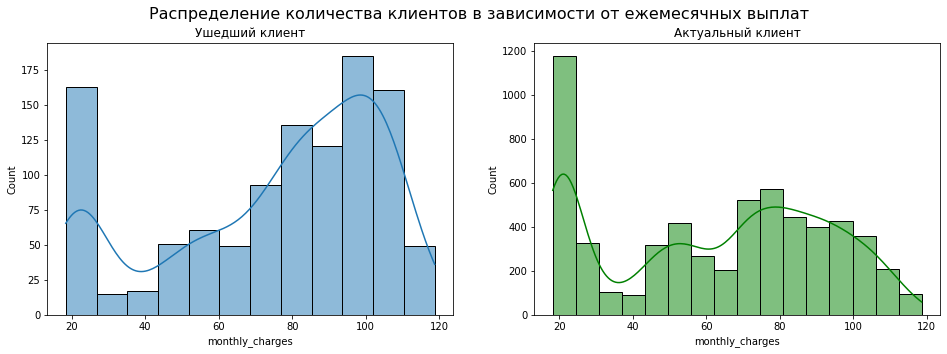

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.histplot(data_full[data_full['is_active'] == 0]['monthly_charges'], 
             ax = ax1, kde=True).set_title('Ушедший клиент')
sns.histplot(data_full[data_full['is_active'] == 1]['monthly_charges'], 
             ax = ax2, kde=True, color='green').set_title('Актуальный клиент')
fig.suptitle('Распределение количества клиентов в зависимости от ежемесячных выплат', fontsize=16);

Также рассмотрим распределение количества клиентов в зависимости от выплат за все время. Так, заметим, что оба графика близки к нормальному распрделению, но данные скожены вправо. Для ушедших клиинтов можем заметить, что при сумме полных выплат от 20 до 1000 рост ушедших клиентов увеличивается, а затем медленно спадает. На втором графике заметим, что количество актуальных клиентов наибольшее при общей сумме вылат от 20 до 2000, а далее идет длинный хвост.

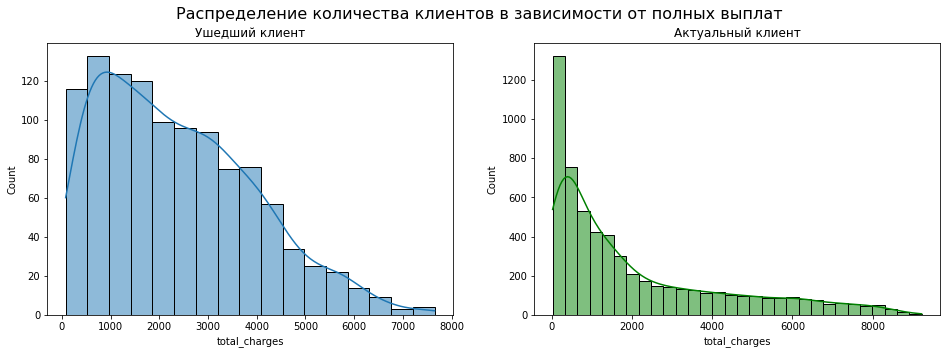

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
sns.histplot(data_full[data_full['is_active'] == 0]['total_charges'], 
             ax = ax1, kde=True).set_title('Ушедший клиент')
sns.histplot(data_full[data_full['is_active'] == 1]['total_charges'], 
             ax = ax2, kde=True, color='green').set_title('Актуальный клиент')
fig.suptitle('Распределение количества клиентов в зависимости от полных выплат', fontsize=16);


### Влияние категориальных признаков
Рассмотрим, как категориальные признаки в данных могут влиять на уход клиента

На графике количества ушедших и активных клиентов в зависимости от метода оплаты можем заметить, что наибольшее количество действующих клиентов предпочитают оплату электронным чеком и меньше всего используют автоматические методы оплаты. Также заметим, что наименьшее количество ушедших пользователей придерживались оплаты чеков по почте. 

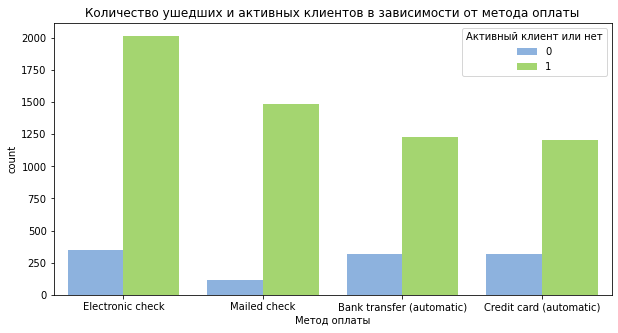

In [51]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'payment_method', hue= 'is_active', data = data_full, palette=['#80B1EB',"#A5E65F"])
plt.title('Количество ушедших и активных клиентов в зависимости от метода оплаты')
plt.xlabel('Метод оплаты')
plt.legend(title='Активный клиент или нет')
plt.show()

На гистограмме ниже представлено количество ушедших и активных клиентов в зависимости от типа оплаты. Заметим, что преобладающим типом оплаты является ежемясячные платежи. Количество ушедших пользователей примерно одинаково для трех категорий, а значит признак 'type'  сильного влияния  на уход пользователя не имеет.

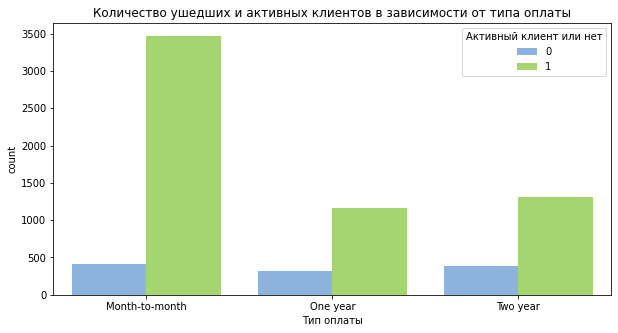

In [52]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'type', hue= 'is_active', data = data_full, palette=['#80B1EB',"#A5E65F"])
plt.title('Количество ушедших и активных клиентов в зависимости от типа оплаты')
plt.xlabel('Тип оплаты')
plt.legend(title='Активный клиент или нет')
plt.show()

Посмотрим на гистограммы количества ушедших и актуальных клиентов в зависимости от дополнительных услуг для пользователей интернет- услуг и телефонии

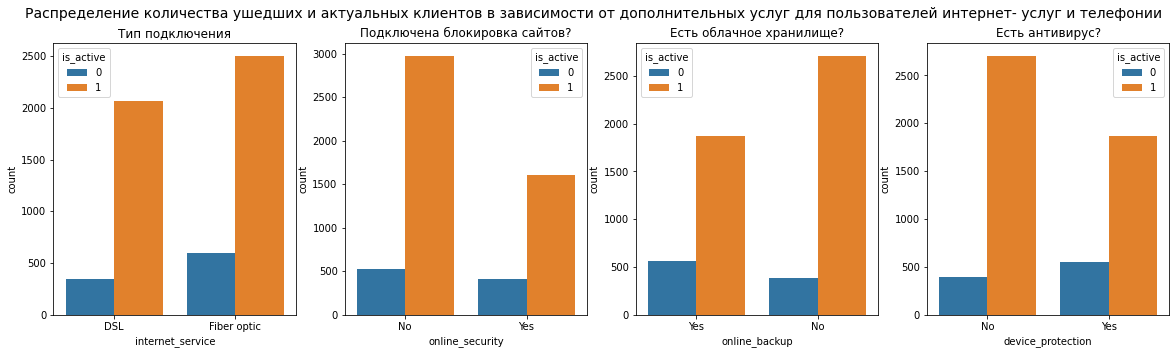

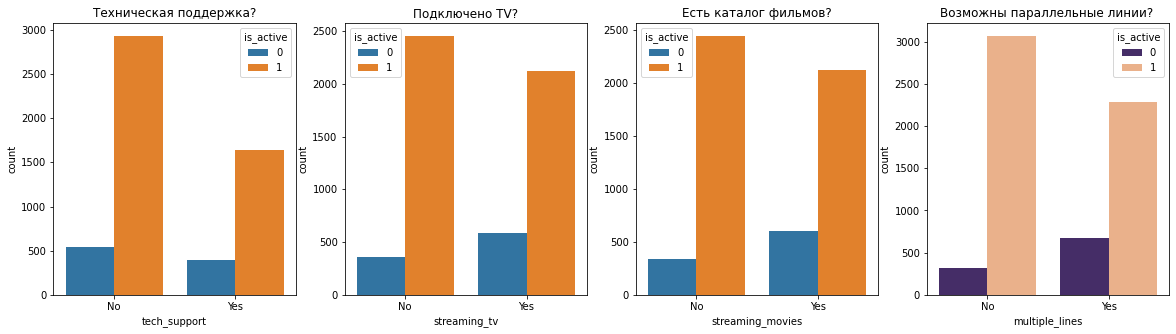

In [53]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
sns.countplot(x = 'internet_service', 
              ax=ax1, hue= 'is_active', data = data_full[data_full['is_internet'] == 1]
             ).set_title('Тип подключения')
sns.countplot(x = 'online_security',ax=ax2, 
              hue= 'is_active', data = data_full[data_full['is_internet'] == 1]
             ).set_title('Подключена блокировка сайтов?')
sns.countplot(x = 'online_backup',ax=ax3, 
              hue= 'is_active', data = data_full[data_full['is_internet'] == 1]
             ).set_title('Есть облачное хранилище?')
sns.countplot(x = 'device_protection',
              ax=ax4, hue= 'is_active', data = data_full[data_full['is_internet'] == 1]
             ).set_title('Есть антивирус?')
fig.suptitle('Распределение количества ушедших и актуальных клиентов \
в зависимости от дополнительных услуг для пользователей интернет- услуг и телефонии', fontsize=14);

fig2, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
sns.countplot(x = 'tech_support', ax=ax1, 
              hue= 'is_active', data = data_full[data_full['is_internet'] == 1]
             ).set_title('Техническая поддержка?')
sns.countplot(x = 'streaming_tv',ax=ax2,
              hue= 'is_active', data = data_full[data_full['is_internet'] == 1]
             ).set_title('Подключено TV?')
sns.countplot(x = 'streaming_movies',ax=ax3,
              hue= 'is_active', data = data_full[data_full['is_internet'] == 1]
             ).set_title('Есть каталог фильмов?')
sns.countplot(x = 'multiple_lines',ax=ax4, hue= 'is_active', 
              data = data_full[data_full['is_phone'] == 1], palette=['#432371',"#FAAE7B"]
             ).set_title('Возможны параллельные линии? ');

 Для клиентов интернет услуг:
 
 - По гистаграмме типа подключения можем увидеть, что большинство клиентов выбирали оптоволоконный тип подключения
 - На гистограмме соотношения активных и ушедщих клиентов в зависимости от подключения услуги блокировки вредоносных сайтов можем заметить, что большее количество клиентов не было к ней подключено, при этом колчество ушедших клиентов практически не зависит от подключения к этой услуге.
 - Признак наличия облачного хранилища заметно влияет на уход клиента, ведь большинство актуальных клиентов не пользуются эиой услугой, а для ушедших наоборот - большинство ушедших клинтов были подключены к облачносу хранилищу.
 - Из гистограммы наличия антивируса известно, что большее количество ушедших клиентов этой услугой пользовались, это важный признак.
 - Наличие услуги технической поддержки также имеется у меньшего числа пользователей.
 - Признак стримингового телевидения кажется интересным, ведь большее количество неактивных клиентов были к нему подключены.
 - Наличие каталогов фильма аналогично предыдущему признаку является важным.
 
 
 Для клиентов телефонии:
 
 - Для клиентов телефонии представлена гистограмма наличия возможности ведения параллельных линий. Здесь у большинства активных пользователей такой функции нет, а большинство ушедших пользователей, наоборот, были подключены к этому сервису.


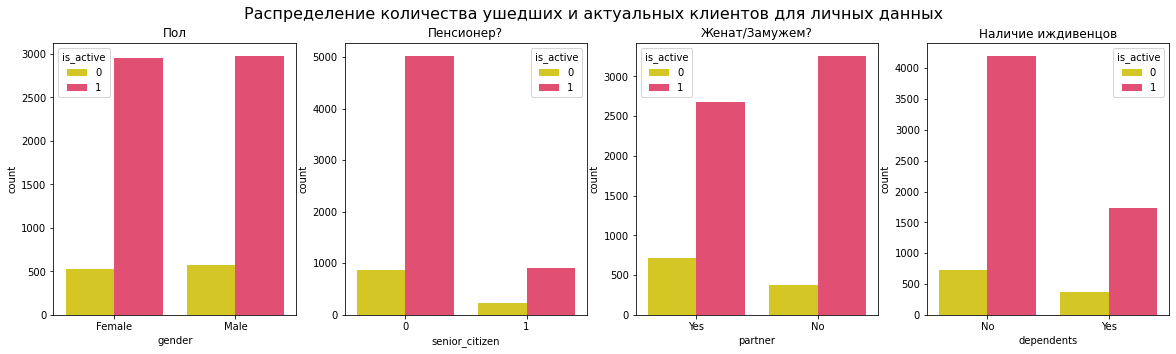

In [54]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
sns.countplot(x = 'gender', ax=ax1, hue= 'is_active', 
              data = data_full, palette=['#F1DF07',"#F93765"]
             ).set_title('Пол')
#plt.title('Количество ушедших и активных клиентов в от типа оплаты')
#plt.xlabel('Тип оплаты')

sns.countplot(x = 'senior_citizen',ax=ax2, hue= 'is_active', 
              data = data_full, palette=['#F1DF07',"#F93765"]
             ).set_title('Пенсионер?')
sns.countplot(x = 'partner',ax=ax3, hue= 'is_active', 
              data = data_full, palette=['#F1DF07',"#F93765"]
             ).set_title('Женат/Замужем?')
sns.countplot(x = 'dependents',ax=ax4, hue= 'is_active', 
              data = data_full,  palette=['#F1DF07',"#F93765"]
             ).set_title('Наличие иждивенцов')
fig.suptitle('Распределение количества ушедших и актуальных клиентов для личных данных',fontsize=16);

Построим гистограммы количества ушедших и актуальных клиентов по личным данным клиентов

- Заметим, что количество мужчин и женщин практически одинаковое, признак gender не влияет на уход клиента.
- А вот признак является ли человек пенсионером является важным.
- А вот количество ушедших пользователей, имеющих пару, превышает количество свободных клиентов.
- Признак наличия иждевенцев также влияет на уход клиента, клиенты имеющие иждевенцев уходят чаще.



### Корреляция признаков
Для того, чтобы определить, как влияют друг на друга численные признаки построим тепловую карту корреляции Пирсона, а также матрицу рассеивания между признаками.

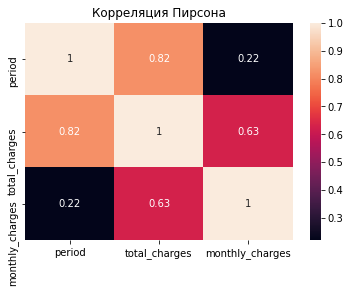

In [55]:
plt.title('Корреляция Пирсона');
sns.heatmap(data_full[['period', 'total_charges', 'monthly_charges']].corr(), annot = True, fmt='.2g');

По heatmap корреляции Пирсона можем заметить, что признак 'total_charges' имеет заметную корреляция с признаком 'monthly_charges', коэффициент Пиросна составляет 0.63. Такая корреляция для двух признаков описывающих траты вполне ожидаема. Также 'total_charges' имеет высокую корреляцию с 'period' порядка 0.82, что означает прямую зависимость между увелечением периода активности клиента и его полными выплатами.

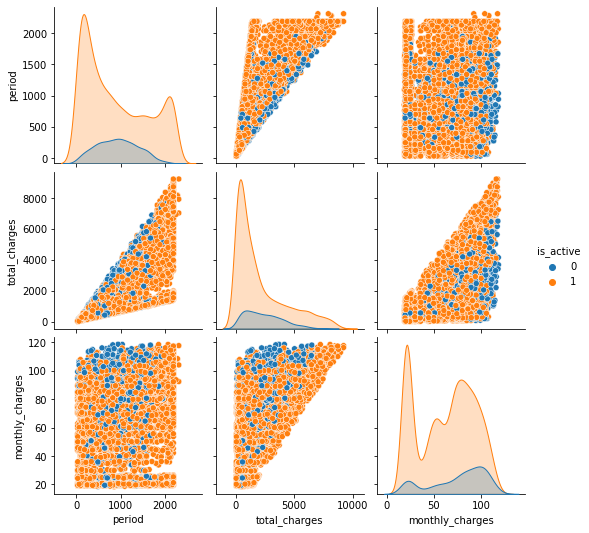

In [56]:
sns.pairplot(data_full[['period', 'total_charges',
                        'monthly_charges', 'is_active']], hue= 'is_active')

На матрице рассеиваяния можем увидеть линейные зависимости между признаками полных выплат и периода и полных выплат и ежемесчных выплат. Такая высокая корреляция признака 'total_charges' может повлиять на адекватность модели, поэтому уадлим этот признак.

### Подготовка выборок
На этом этапе удалим высококореллирующие столбцы и неинформативные столбцы, разделим данные на обучающие и тестовые выборки.

In [57]:
data_full = data_full.drop(['customer_id', 'end_date', 'total_charges', 'gender', 'begin_date'], axis=1)

In [58]:
data_full['is_internet'] = data_full['is_internet'].astype('int64')
data_full['is_phone'] = data_full['is_phone'].astype('int64')

In [59]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   is_active          7032 non-null   int64  
 5   multiple_lines     7032 non-null   object 
 6   internet_service   7032 non-null   object 
 7   online_security    7032 non-null   object 
 8   online_backup      7032 non-null   object 
 9   device_protection  7032 non-null   object 
 10  tech_support       7032 non-null   object 
 11  streaming_tv       7032 non-null   object 
 12  streaming_movies   7032 non-null   object 
 13  senior_citizen     7032 non-null   int64  
 14  partner            7032 non-null   object 
 15  dependents         7032 non-null   object 
 16  is_internet        7032 

Разделим данные на обучающую и тестовую выборки

In [60]:
#Разобьем датасет на тренировочные и тестовые выборки
features = data_full.drop('is_active', axis=1)
target = data_full['is_active']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                             target, test_size=0.25, 
                                             random_state=RANDOM_STATE)

In [61]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 3369 to 5349
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5274 non-null   object 
 1   paperless_billing  5274 non-null   object 
 2   payment_method     5274 non-null   object 
 3   monthly_charges    5274 non-null   float64
 4   multiple_lines     5274 non-null   object 
 5   internet_service   5274 non-null   object 
 6   online_security    5274 non-null   object 
 7   online_backup      5274 non-null   object 
 8   device_protection  5274 non-null   object 
 9   tech_support       5274 non-null   object 
 10  streaming_tv       5274 non-null   object 
 11  streaming_movies   5274 non-null   object 
 12  senior_citizen     5274 non-null   int64  
 13  partner            5274 non-null   object 
 14  dependents         5274 non-null   object 
 15  is_internet        5274 non-null   int64  
 16  is_phone           52

In [62]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 6130 to 4625
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               1758 non-null   object 
 1   paperless_billing  1758 non-null   object 
 2   payment_method     1758 non-null   object 
 3   monthly_charges    1758 non-null   float64
 4   multiple_lines     1758 non-null   object 
 5   internet_service   1758 non-null   object 
 6   online_security    1758 non-null   object 
 7   online_backup      1758 non-null   object 
 8   device_protection  1758 non-null   object 
 9   tech_support       1758 non-null   object 
 10  streaming_tv       1758 non-null   object 
 11  streaming_movies   1758 non-null   object 
 12  senior_citizen     1758 non-null   int64  
 13  partner            1758 non-null   object 
 14  dependents         1758 non-null   object 
 15  is_internet        1758 non-null   int64  
 16  is_phone           17

In [63]:
target_train

3369    1
656     1
5074    1
3315    1
1468    1
       ..
1489    0
6870    1
338     1
440     1
5349    1
Name: is_active, Length: 5274, dtype: int64

Создадим Pipeline для предобратки данных. Для маштабирования численных значений используем StandardScaler, а для кодирования категориальных признаков - OrdinalEncoder.

In [64]:
numerical = ['monthly_charges', 'period']
to_dummies = ['type', 'paperless_billing', 'payment_method','multiple_lines', 'internet_service',
             'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 
             'streaming_movies','senior_citizen', 'partner', 'dependents', 'is_internet', 'is_phone']

#other = ['is_active','senior_citizen', 'is_internet', 'period' ]

In [65]:
# Объявляем scaler и OrdinalEncoder() для числовых и категориальных переменных соответственно

scaler = StandardScaler() 

ohe = OrdinalEncoder()
# Делаем pipeline для числовых переменных датасета

numerical_selector = FunctionTransformer(lambda data: data[numerical], validate=False)
numerical_preprocessor = Pipeline([("numerical_selector", numerical_selector), ("scaling", scaler)])

# Делаем pipeline для категориальных переменных датасета

dummy_selector = FunctionTransformer(lambda data: data[to_dummies], validate=False)
dummy_preprocessor = Pipeline([("dummy_selector", dummy_selector), ("ohe", ohe)])

# Объединяем созданные выше pipeline в один с помощью функции 
#FeatureUnion и затем записываем итоговый pipeline на примере логистической регрессии

feature_union = FeatureUnion([("numerical_preprocessor", numerical_preprocessor),
("dummy_preprocessor", dummy_preprocessor)])



## Модели
На этом этапе построим модели машинного обучения, подбор оптимальных гиперпараметров осуществляется с помощью Optuna.
Метрика качества - roc-auc. 

In [66]:
def feature_importance(model, numerical, to_dummies):
    fig = pd.DataFrame(model.best_estimator_[-1].feature_importances_, 
                       index=numerical+ to_dummies, columns =['Importance']
                ).sort_values(by='Importance').plot(kind='barh',figsize = (18,6), 
                                                title ='Feature Importances');  
    plt.show()
    return 

### Дерево принятия решений

In [67]:
pipeline_dt = Pipeline([('preprocess', feature_union), ('model', 
                                                        DecisionTreeClassifier(class_weight = 'balanced', 
                                                                               random_state=RANDOM_STATE))])
parameters_dt = {
              'model__max_depth': optuna.distributions.IntDistribution(3,20),
              'model__min_samples_split': optuna.distributions.IntDistribution(2, 5)} 


optuna_dt = OptunaSearchCV(pipeline_dt, parameters_dt, n_trials=30, cv=3, n_jobs=-1,
                                  scoring='roc_auc', random_state=RANDOM_STATE) 
optuna_dt.fit(features_train, target_train)

#pred_dt = optuna_dt.predict(features_train)

/tmp/ipykernel_846/3954703931.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_dt = OptunaSearchCV(pipeline_dt, parameters_dt, n_trials=30, cv=3, n_jobs=-1,
[I 2023-06-03 00:51:34,728] A new study created in memory with name: no-name-ecc1c950-32ad-41af-8d6e-55ca0ba4cddf
[I 2023-06-03 00:51:35,964] Trial 0 finished with value: 0.7324200220830823 and parameters: {'model__max_depth': 3, 'model__min_samples_split': 2}. Best is trial 0 with value: 0.7324200220830823.
[I 2023-06-03 00:51:36,556] Trial 1 finished with value: 0.69757033307626 and parameters: {'model__max_depth': 10, 'model__min_samples_split': 2}. Best is trial 0 with value: 0.7324200220830823.
[I 2023-06-03 00:51:36,655] Trial 4 finished with value: 0.6292686352366943 and parameters: {'model__max_depth': 19, 'model__min_samples_split': 3}. Best is trial 0 with value: 0.7324200220830823.
[I 2023-06-03 00:51:36,761] Trial 3 finished with value: 

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocess',
                                          FeatureUnion(transformer_list=[('numerical_preprocessor',
                                                                          Pipeline(steps=[('numerical_selector',
                                                                                           FunctionTransformer(func=<function <lambda> at 0x7f62f51aed30>)),
                                                                                          ('scaling',
                                                                                           StandardScaler())])),
                                                                         ('dummy_preprocessor',
                                                                          Pipeline(steps=[('dummy_selector',
                                                                                           FunctionTransformer(func=<function <lambda> at 0x7f62f51ae280>)),
                                                                                          ('ohe',
                                                                                           OrdinalEncoder())]))])),
                                         ('model',
                                          DecisionTreeClassifier(class_weight='balanced',
                                                                 random_state=220523))]),
               n_jobs=-1, n_trials=30,
               param_distributions={'model__max_depth': IntDistribution(high=20, log=False, low=3, step=1),
                                    'model__min_samples_split': IntDistribution(high=5, log=False, low=2, step=1)},
               random_state=220523, scoring='roc_auc')

In [68]:
print('Лучшие гипераметры:', optuna_dt.best_params_)
print('ROC-AUC на тренировочной выборке:', optuna_dt.best_score_)
print('Время обучения', optuna_dt.refit_time_)
print()


Лучшие гипераметры: {'model__max_depth': 6, 'model__min_samples_split': 5}
ROC-AUC на тренировочной выборке: 0.7792472421920769
Время обучения 0.04926753044128418



### LightGBM

In [69]:
pipeline_lgbm = Pipeline([('preprocess', feature_union),  ('model', LGBMClassifier(class_weight = 'balanced', random_state=RANDOM_STATE))]) 
parameters_lgbm = {
    'model__max_depth': optuna.distributions.IntDistribution(2, 15),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'model__n_estimators': optuna.distributions.IntDistribution(100, 1000, step=50)
}


optuna_lgbm = OptunaSearchCV(pipeline_lgbm, parameters_lgbm, n_trials=16, cv=3, n_jobs=-1, scoring='roc_auc', random_state=RANDOM_STATE) 
optuna_lgbm.fit(features_train, target_train)



/tmp/ipykernel_846/1959402214.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_lgbm = OptunaSearchCV(pipeline_lgbm, parameters_lgbm, n_trials=16, cv=3, n_jobs=-1, scoring='roc_auc', random_state=RANDOM_STATE)
[I 2023-06-03 00:51:42,205] A new study created in memory with name: no-name-1467e42a-a263-4fdc-bd9f-dfdbf859d9e7
[I 2023-06-03 00:51:53,171] Trial 7 finished with value: 0.8011789574666142 and parameters: {'model__max_depth': 2, 'model__learning_rate': 0.009756105073608733, 'model__n_estimators': 150}. Best is trial 7 with value: 0.8011789574666142.
[I 2023-06-03 00:53:33,970] Trial 0 finished with value: 0.8261510424223619 and parameters: {'model__max_depth': 5, 'model__learning_rate': 0.012965438660905321, 'model__n_estimators': 350}. Best is trial 0 with value: 0.8261510424223619.
[I 2023-06-03 00:53:38,063] Trial 4 finished with value: 0.86849561261065 and parameters: {'model__max_depth': 4, '

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocess',
                                          FeatureUnion(transformer_list=[('numerical_preprocessor',
                                                                          Pipeline(steps=[('numerical_selector',
                                                                                           FunctionTransformer(func=<function <lambda> at 0x7f62f51aed30>)),
                                                                                          ('scaling',
                                                                                           StandardScaler())])),
                                                                         ('dummy_preprocessor',
                                                                          Pipeline(steps=[('dummy_selector',
                                                                                           FunctionTransformer(func=<function <lambda> at 0...
                                          LGBMClassifier(class_weight='balanced',
                                                         random_state=220523))]),
               n_jobs=-1, n_trials=16,
               param_distributions={'model__learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                    'model__max_depth': IntDistribution(high=15, log=False, low=2, step=1),
                                    'model__n_estimators': IntDistribution(high=1000, log=False, low=100, step=50)},
               random_state=220523, scoring='roc_auc')

In [70]:
print('Лучшие гипераметры:', optuna_lgbm.best_params_)
print('ROC-AUC на тренировочной выборке:', optuna_lgbm.best_score_)
print('Время обучения', optuna_lgbm.refit_time_)

Лучшие гипераметры: {'model__max_depth': 4, 'model__learning_rate': 0.06447228572656513, 'model__n_estimators': 700}
ROC-AUC на тренировочной выборке: 0.86849561261065
Время обучения 304.610298871994


### XGBoost

In [71]:
pipeline_xgb = Pipeline([('preprocess', feature_union),  ('model', XGBClassifier(class_weight = 'balanced',random_state=RANDOM_STATE))]) 

parametrs_xgb = {
    'model__max_depth': optuna.distributions.IntDistribution(3, 15),
    'model__eta': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'model__n_estimators': optuna.distributions.IntDistribution(100, 1000, step=50)
}

optuna_xgb = OptunaSearchCV(pipeline_xgb, parametrs_xgb, n_trials=3, cv=3, n_jobs=-1, scoring='roc_auc', random_state=RANDOM_STATE) 
optuna_xgb.fit(features_train, target_train)



/tmp/ipykernel_846/4245023089.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_xgb = OptunaSearchCV(pipeline_xgb, parametrs_xgb, n_trials=3, cv=3, n_jobs=-1, scoring='roc_auc', random_state=RANDOM_STATE)
[I 2023-06-03 01:11:06,117] A new study created in memory with name: no-name-16772017-89df-4d71-8adb-8e130f422a39
/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[01:11:06] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters g

[01:45:01] WARNING: ../src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:45:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocess',
                                          FeatureUnion(transformer_list=[('numerical_preprocessor',
                                                                          Pipeline(steps=[('numerical_selector',
                                                                                           FunctionTransformer(func=<function <lambda> at 0x7f62f51aed30>)),
                                                                                          ('scaling',
                                                                                           StandardScaler())])),
                                                                         ('dummy_preprocessor',
                                                                          Pipeline(steps=[('dummy_selector',
                                                                                           FunctionTransformer(func=<function <lambda> at 0...
                                                        tree_method=None,
                                                        validate_parameters=None,
                                                        verbosity=None))]),
               n_jobs=-1, n_trials=3,
               param_distributions={'model__eta': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                    'model__max_depth': IntDistribution(high=15, log=False, low=3, step=1),
                                    'model__n_estimators': IntDistribution(high=1000, log=False, low=100, step=50)},
               random_state=220523, scoring='roc_auc')

In [72]:
print('Лучшие гипераметры:', optuna_xgb.best_params_)
print('ROC-AUC на тренировочной выборке:', optuna_xgb.best_score_)
print('Время обучения', optuna_xgb.refit_time_)

Лучшие гипераметры: {'model__max_depth': 14, 'model__eta': 0.02126022731846486, 'model__n_estimators': 500}
ROC-AUC на тренировочной выборке: 0.8382227454909218
Время обучения 3008.7870099544525


### Catboost

In [73]:
pipeline_catboost = Pipeline([('preprocess', feature_union),  ('model', CatBoostClassifier(random_state=RANDOM_STATE))]) 

parameters_catboost = {
    'model__max_depth': optuna.distributions.IntDistribution(3, 15),
    'model__eta': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'model__n_estimators': optuna.distributions.IntDistribution(100, 1000, step=50)
}

optuna_cat = OptunaSearchCV(pipeline_catboost, parameters_catboost, n_trials=3, cv=3, n_jobs=-1, scoring='roc_auc', random_state=RANDOM_STATE) 
optuna_cat.fit(features_train, target_train)

/tmp/ipykernel_846/1323855425.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_cat = OptunaSearchCV(pipeline_catboost, parameters_catboost, n_trials=3, cv=3, n_jobs=-1, scoring='roc_auc', random_state=RANDOM_STATE)
[I 2023-06-03 02:35:11,585] A new study created in memory with name: no-name-6d734fd6-2be5-4cf3-9b20-1b7eede7391c
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6760219	total: 51.8ms	remaining: 51.8s
0:	learn: 0.6491719	total: 129ms	remaining: 45.1s
1:	learn: 0.6628430	total: 99.5ms	remaining: 49.7s
1:	learn: 0.6185232	total: 132ms	remaining: 22.9s
2:	learn: 0.6483699	total: 101ms	remaining: 33.7s
2:	learn: 0.5881128	total: 140ms	remaining: 16.2s
3:	learn: 0.6331468	total: 103ms	remaining: 25.7s
4:	learn: 0.6194533	total: 105ms	remaining: 21s
5:	learn: 0.6063339	total: 108ms	remaining: 17.8s
6:	learn: 0.5926475	total: 110ms	remaining: 15.5s
3:	learn: 0.5605441	total: 149ms	remaining: 12.9s
7:	learn: 0.5799294	total: 112ms	remaining: 13.9s
8:	learn: 0.5691521	total: 114ms	remaining: 12.5s
4:	learn: 0.5324469	total: 157ms	remaining: 10.8s
0:	learn: 0.6915069	total: 103ms	remaining: 15.4s
9:	learn: 0.5589235	total: 115ms	remaining: 11.4s
5:	learn: 0.5094457	total: 173ms	remaining: 9.93s
10:	learn: 0.5502935	total: 117ms	remaining: 10.5s
1:	learn: 0.6898632	total: 184ms	remaining: 13.6s
6:	learn: 0.4884730	total: 244ms	remaining: 12s
1

[I 2023-06-03 02:36:02,189] Trial 2 finished with value: 0.8018214443602357 and parameters: {'model__max_depth': 9, 'model__eta': 0.003775020888656232, 'model__n_estimators': 150}. Best is trial 2 with value: 0.8018214443602357.


376:	learn: 0.2781128	total: 2.75s	remaining: 4.54s
193:	learn: 0.1926268	total: 7.67s	remaining: 6.17s
377:	learn: 0.2779391	total: 2.76s	remaining: 4.54s
378:	learn: 0.2778242	total: 2.76s	remaining: 4.53s
194:	learn: 0.1923483	total: 7.73s	remaining: 6.14s
379:	learn: 0.2777336	total: 2.76s	remaining: 4.51s
195:	learn: 0.1917356	total: 7.74s	remaining: 6.08s
380:	learn: 0.2776150	total: 2.77s	remaining: 4.49s
196:	learn: 0.1914129	total: 7.75s	remaining: 6.02s
381:	learn: 0.2774374	total: 2.77s	remaining: 4.48s
197:	learn: 0.1911357	total: 7.75s	remaining: 5.95s
382:	learn: 0.2773123	total: 2.77s	remaining: 4.46s
383:	learn: 0.2770832	total: 2.78s	remaining: 4.46s
384:	learn: 0.2770032	total: 2.78s	remaining: 4.44s
198:	learn: 0.1908978	total: 7.77s	remaining: 5.9s
385:	learn: 0.2768416	total: 2.78s	remaining: 4.43s
700:	learn: 0.2279140	total: 4.82s	remaining: 2.06s
134:	learn: 0.5223241	total: 7.21s	remaining: 801ms
701:	learn: 0.2276282	total: 4.83s	remaining: 2.05s
135:	learn: 0

[I 2023-06-03 02:36:41,566] Trial 1 finished with value: 0.8629427499357729 and parameters: {'model__max_depth': 8, 'model__eta': 0.04900753489765758, 'model__n_estimators': 350}. Best is trial 1 with value: 0.8629427499357729.


s	remaining: 239ms
350:	learn: 0.2701043	total: 2.56s	remaining: 4.73s
351:	learn: 0.2700038	total: 2.56s	remaining: 4.72s
343:	learn: 0.1325699	total: 11.7s	remaining: 204ms
352:	learn: 0.2698127	total: 2.56s	remaining: 4.7s
344:	learn: 0.1320464	total: 11.7s	remaining: 170ms
353:	learn: 0.2697142	total: 2.57s	remaining: 4.68s
354:	learn: 0.2695319	total: 2.57s	remaining: 4.67s
345:	learn: 0.1317304	total: 11.7s	remaining: 136ms
355:	learn: 0.2694779	total: 2.57s	remaining: 4.65s
356:	learn: 0.2693302	total: 2.57s	remaining: 4.63s
357:	learn: 0.2691636	total: 2.57s	remaining: 4.62s
346:	learn: 0.1313649	total: 11.8s	remaining: 102ms
358:	learn: 0.2690075	total: 2.58s	remaining: 4.6s
359:	learn: 0.2688683	total: 2.58s	remaining: 4.58s
347:	learn: 0.1311364	total: 11.9s	remaining: 68.5ms
360:	learn: 0.2687575	total: 2.58s	remaining: 4.57s
348:	learn: 0.1309775	total: 12s	remaining: 34.4ms
361:	learn: 0.2686213	total: 2.58s	remaining: 4.55s
349:	learn: 0.1308250	total: 12s	remaining: 0us

[I 2023-06-03 02:37:00,174] Trial 0 finished with value: 0.8892364808310553 and parameters: {'model__max_depth': 5, 'model__eta': 0.022221984772162976, 'model__n_estimators': 1000}. Best is trial 0 with value: 0.8892364808310553.


0:	learn: 0.6761754	total: 42ms	remaining: 42s
1:	learn: 0.6584116	total: 44.4ms	remaining: 22.1s
2:	learn: 0.6410404	total: 47.2ms	remaining: 15.7s
3:	learn: 0.6266080	total: 49.5ms	remaining: 12.3s
4:	learn: 0.6152291	total: 51ms	remaining: 10.2s
5:	learn: 0.6004650	total: 55.5ms	remaining: 9.19s
6:	learn: 0.5871529	total: 122ms	remaining: 17.3s
7:	learn: 0.5750517	total: 126ms	remaining: 15.7s
8:	learn: 0.5656032	total: 129ms	remaining: 14.2s
9:	learn: 0.5529232	total: 131ms	remaining: 13s
10:	learn: 0.5431893	total: 139ms	remaining: 12.5s
11:	learn: 0.5330719	total: 141ms	remaining: 11.6s
12:	learn: 0.5256390	total: 144ms	remaining: 10.9s
13:	learn: 0.5173150	total: 148ms	remaining: 10.4s
14:	learn: 0.5082128	total: 150ms	remaining: 9.85s
15:	learn: 0.4998892	total: 155ms	remaining: 9.54s
16:	learn: 0.4924313	total: 157ms	remaining: 9.1s
17:	learn: 0.4856235	total: 160ms	remaining: 8.71s
18:	learn: 0.4798671	total: 167ms	remaining: 8.6s
19:	learn: 0.4723834	total: 169ms	remaining: 

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocess',
                                          FeatureUnion(transformer_list=[('numerical_preprocessor',
                                                                          Pipeline(steps=[('numerical_selector',
                                                                                           FunctionTransformer(func=<function <lambda> at 0x7f62f51aed30>)),
                                                                                          ('scaling',
                                                                                           StandardScaler())])),
                                                                         ('dummy_preprocessor',
                                                                          Pipeline(steps=[('dummy_selector',
                                                                                           FunctionTransformer(func=<function <lambda> at 0...
                                          <catboost.core.CatBoostClassifier object at 0x7f62f535eb80>)]),
               n_jobs=-1, n_trials=3,
               param_distributions={'model__eta': FloatDistribution(high=0.1, log=True, low=0.001, step=None),
                                    'model__max_depth': IntDistribution(high=15, log=False, low=3, step=1),
                                    'model__n_estimators': IntDistribution(high=1000, log=False, low=100, step=50)},
               random_state=220523, scoring='roc_auc')

In [74]:
print('Лучшие гипераметры:', optuna_cat.best_params_)
print('ROC-AUC на тренировочной выборке:', optuna_cat.best_score_)
print('Время обучения', optuna_cat.refit_time_)

Лучшие гипераметры: {'model__max_depth': 5, 'model__eta': 0.022221984772162976, 'model__n_estimators': 1000}
ROC-AUC на тренировочной выборке: 0.8892364808310553
Время обучения 29.693673372268677


При исследовании задачи был выявлен дисбаланс классов. Активных пользователей почти в 6 раза больше, чем ушедших, поэтому для моделей неустойчивых к дисбалансу классов применен метод борьбы с дисбалансом - метод взвешивания классов. 
Для поиска наилучшей модели использовали подбор гиперпараметров с помощью optuna и получили следующие результаты. 

- Для модели дерева принятия решения с оптимальной глубиной дерева, равной 6 и минимальным числом объектов, необходимое для того, чтобы узел дерева мог бы расщепиться (min_samples_split ) ROC-AUC метрика равна 0.779. Время обучения составляет 0.024.

- Для модели LGBMClassifier оптимальные гиперпараметры при сбалансированных тренировачных данных такие: количество деревьев - 750, максимальная глубина- 2, коэффициент скорости обучения равен 0.08. Значение ROC-AUC равно 0.88. Время обучения составляет 0.28.

- Модель XGBClassifier показывает значение метрики ROC-AUC равное 0.884, что немного превышает качество LGBM модели. Лучшие значения гиперпараметров модели XGBClassifier следующие: максимальная глубина = 5, скорость обучения равна 0.05, а количество деревьев равно 450. Время обучения составляет 0.76.

- Модель CatBoostClassifier не нуждается в балансировке классов. Но с такими гиперпараметрами, как максимальная глубина, равная 11, скороть обучения, равная 0.04, число деревьев, равное 800, модель показывает метрику качества ROC-AUC = 0.85 и уступает в качестве всем моделям, кроме дерева принятия решений. Также время обучения модели catboost самое большое, оно составляет 13.2.


По итогам анализа моделей на тестовой выборке модели XGBClassifier и LGBMClassifier показывают близкие высокие значения метрики, при этом модель LGBMClassifier обучается в два раза быстрее. Но все же ROC-AUC XGBClassifier имеет самое высокое значения, поэтому выбираем эту модель в качестве наилучшей.

## Тестирование

In [75]:
best_model = optuna_xgb
prediction = best_model.predict(features_test)
print('accuracy =', accuracy_score(target_test, prediction))

accuracy = 0.8794084186575654


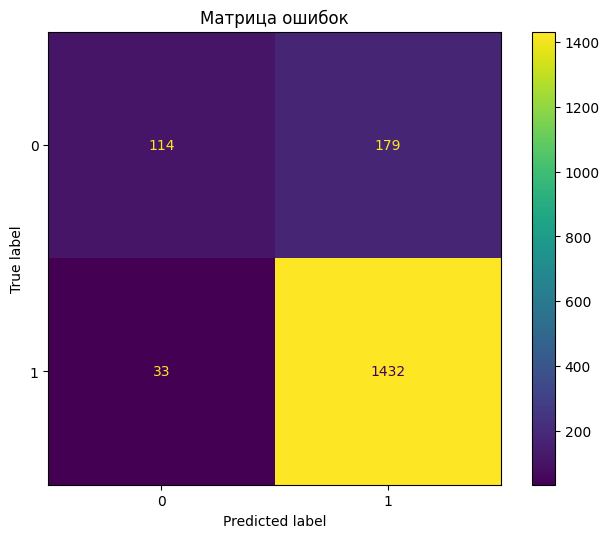

In [76]:

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(confusion_matrix(target_test, prediction), display_labels=best_model.classes_)

ax.set(title='Матрица ошибок') 
display.plot(ax=ax);

ROC-AUC =  0.8754277859963424


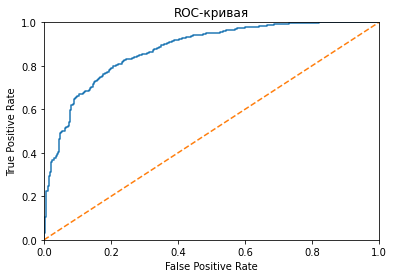

In [77]:
probabilities_valid = best_model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)# < напишите код здесь >

print('ROC-AUC = ', roc_auc_score(target_test, probabilities_one_valid))
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show() 

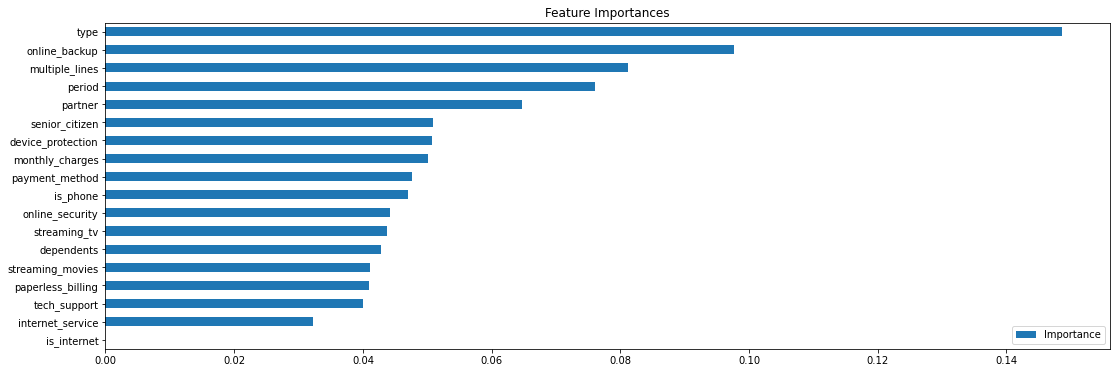

In [78]:
feature_importance(best_model, numerical, to_dummies)

Таким образом, получилось достичь метрики ROC-AUC = 0.87 на тесте для модели XGBClassifier. Мы получили отличный результат, и график ROC - кривой показывает нам адекватность результата. Также из гистограммы важности признаков заметим, что самыми значительными для модели XGBClassifier оказались признаки наличия оюлачного хранилища данных для резервных копий, тип оплаты, наличие мультиканальных линий, период жизни клиента, наличие партнера. Также можем заметить, что все исполльзуемые нами признаки оказались достаточно значимыми для модели.

## Отчет

В ходе работы были выполнены все задачи проекта и была достигнута главная цель - решение задачи прогнозирования оттока клинтов. В проекте представлена модель, которая по данным признакам предсказывает уйдет клиент или нет с высокой точностью. 

- Подготовка данных

На этапе подготовки данных ознакомились с данными четырех таблицах, с помощью которых рещаем задачу классификации. Можем заметить, что во всех таблицах отсутсвуют явные пропуски в данных и дубликаты строк. Целевой признак в задаче - столбец is_active, который отвечает на вопрос действующий клиент или нет. 
На этом шаге удалось обнаружить дисбаланс классов. Активных пользователей почти в 6 раза больше, чем ушедших.

- Анализ данных

На этапе анализа данных были обьеденнены четыре датасета в один. При этом образовавшиеся пропуски обусловлены тем, что не все клиенты, пользующиеся услугами телефонии являются клиентами интернет сервиса и наоборот. Заполнили эти пропуски значениями No, и создали новый признак is_internet, который будет отвечать на вопрос, пользуется ли клиент интернет услагми. Таким образом, клиенты делятся на два типа, те кто пользуются только услугами телефонии и на тех, кто пользуется услугами телефонии и интернета либо только интернета. Также создали столбец is_phone, чтобы аналагичным образом разделить клиентов на тех, кто пользуется только услагами интернета и остальных. Был создан новый столбец period, который показывает время жизни клиента.

Также были построены диаграммы размаха для численнных значений датасета. На диаграмме размаха для ежемесячных выплат можем заметить, что выбросов нет, медиана равна 70.35. Медиана в столбце общих трат равна 1345.275, также заметим, что в этом столбце есть аномально большое количество трат (больше 1461) - это выбросы. Для значений периода активности клиента медиана составляет 761 день, выбросов в этом столбце нет.

Посмотрим на график распределения количества ушедших клиентов, а также на рост клиентов во времени. На графике роста клиентов заметим два локальных максимума в начале 2014 и середине 2019 годов, в остальное время прирост новых клиентов был постоянным в районе 350 клиентов в 4.5 месяца. Такие всплески роста могут быть связаны с проведенными пиар-компаниями и тд. Из графика по количеству ушедших клиентов видно, что число актуальных клиентов падает с каждым годом при равномерном приросте пользователей с 2015-2019 года, а значит действительно есть смысл в разработке стратегии по удержанию клиентов.

На графике распределения количества клиентов в зависимости от времени жизни клиента можно увидеть два пика: в районе от 0 до 500 дней и в районе 2000 дней. Эти пики говорят о том, что актуальные пользователи делятся условно на три группы: новые клиенты (от 0 до 500 дней), надежные клиенты (от 500 до 2000) и преданные клиенты компании (более 2000 дней). Из второго графика распределения ушедших клиентов можем заметить, что новых клиентов много, но также новые клиенты с периодом пользования от 0 до 1000 дней быстрее уходят. Пик периода жизни уходящего клиента приходится на 1000 дней, а далее клиенты уходят с меньшей регулярностью. Таким образом, можно сделать вывод о том, что самый опасный период, в который следует принять меры, чтобы клиент не ушел, приходится на диапазон от 0 до 1000 дней.

Посмотрим на графики распределения количества клиентов в зависимости от ежемесячных выплат. На обоих графиках, для ушедших и актуальных клиентов, можем заметить несколько групп. Есть большое количество пользователей, которые платят ежемясчные платежи в интервале от 20 - 40, также есть большая группа пользователей, чьи ежемесячные выплаты составляют от 80 и больше. Получаем, что клиенты в основном делятся на две категории: с крупными и малыми ежемесячными платежами.

Из графиков распределения количества клиентов в зависимости от выплат за все время заметим, что оба графика близки к нормальному распрделению, но данные скожены вправо. Для ушедших клиинтов можем заметить, что при сумме полных выплат от 20 до 1000 рост ушедших клиентов увеличивается, а затем медленно спадает. На втором графике заметим, что количество актуальных клиентов наибольшее при общей сумме вылат от 20 до 2000, а далее идет длинный хвост.

Также было проанализировано, как категориальные признаки в данных влияют на уход клиента.

На графике количества ушедших и активных клиентов в зависимости от метода оплаты можем заметить, что наибольшее количество действующих клиентов предпочитают оплату электронным чеком и меньше всего используют автоматические методы оплаты. Также заметим, что наименьшее количество ушедших пользователей придерживались оплаты чеков по почте. 

На гистограмме количества ушедших и активных клиентов в зависимости от типа оплаты заметим, что преобладающим типом оплаты является ежемясячные платежи. Количество ушедших пользователей примерно одинаково для трех категорий, а значит признак 'type'.

Посмотрим на гистограммы количества ушедших и актуальных клиентов в зависимости от дополнительных услуг для пользователей интернет услуг и телефони.

Для клиентов интернет услуг:
 
 - По гистаграмме типа подключения можем увидеть, что большинство клиентов выбирали оптоволоконный тип подключения
 - На гистограмме соотношения активных и ушедщих клиентов в зависимости от подключения услуги блокировки вредоносных сайтов можем заметить, что большее количество клиентов не было к ней подключено, при этом колчество ушедших клиентов практически не зависит от подключения к этой услуге.
 - Признак наличия облачного хранилища заметно влияет на уход клиента, ведь большинство актуальных клиентов не пользуются эиой услугой, а для ушедших наоборот - большинство ушедших клинтов были подключены к облачносу хранилищу.
 - Из гистограммы наличия антивируса известно, что большее количество ушедших клиентов этой услугой пользовались, это важный признак.
 - Наличие услуги технической поддержки также имеется у меньшего числа пользователей.
 - Признак стримингового телевидения кажется интересным, ведь большее количество неактивных клиентов были к нему подключены.
 - Наличие каталогов фильма аналогично предыдущему признаку является важным.
 
 
 Для клиентов телефонии:
 
 - Для клиентов телефонии представлена гистограмма наличия возможности ведения параллельных линий. Здесь у большинства активных пользователей такой функции нет, а большинство ушедших пользователей, наоборот, были подключены к этому сервису.

Для того, чтобы определить, как влияют друг на друга численные признаки построили тепловую карту корреляции Пирсона, а также матрицу рассеивания между признаками.

По heatmap корреляции Пирсона можем заметить, что признак 'total_charges' имеет заметную корреляция с признаком 'monthly_charges', коэффициент Пиросна составляет 0.63. Такая корреляция для двух признаков описывающих траты вполне ожидаема. Также 'total_charges' имеет высокую корреляцию с 'period' порядка 0.82, что означает прямую зависимость между увелечением периода активности клиента и его полными выплатами. 

На матрице рассеиваяния можем увидеть линейные зависимости между признаками полных выплат и периода и полных выплат и ежемесчных выплат. Такая высокая корреляция признака 'total_charges' может повлиять на адекватность модели, поэтому уадлим этот признак.

- Предобратока данных

На этом этапе удалили высококореллирующие столбцы и неинформативные столбцы, разделили данные на обучающие и тестовые выборки. Также создали Pipeline для предобратки данных. Для маштабирования численных значений используем StandardScaler, а для кодирования категориальных признаков - OrdinalEncoder.

- Построение модели

Для поиска наилучшей модели использовали подбор гиперпараметров с помощью optuna и получили следующие результаты. 

- Для модели дерева принятия решения с оптимальной глубиной дерева, равной 6 и минимальным числом объектов, необходимое для того, чтобы узел дерева мог бы расщепиться (min_samples_split ) ROC-AUC метрика равна 0.779. Время обучения составляет 0.024.

- Для модели LGBMClassifier оптимальные гиперпараметры при сбалансированных тренировачных данных такие: количество деревьев - 750, максимальная глубина- 2, коэффициент скорости обучения равен 0.08. Значение ROC-AUC равно 0.88. Время обучения составляет 0.28.

- Модель XGBClassifier показывает значение метрики ROC-AUC равное 0.884, что немного превышает качество LGBM модели. Лучшие значения гиперпараметров модели XGBClassifier следующие: максимальная глубина = 5, скорость обучения равна 0.05, а количество деревьев равно 450. Время обучения составляет 0.76.

- Модель CatBoostClassifier не нуждается в балансировке классов. Но с такими гиперпараметрами, как максимальная глубина, равная 11, скороть обучения, равная 0.04, число деревьев, равное 800, модель показывает метрику качества ROC-AUC = 0.85 и уступает в качестве всем моделям, кроме дерева принятия решений. Также время обучения модели catboost самое большое, оно составляет 13.2.


По итогам анализа моделей на тестовой выборке модели XGBClassifier и LGBMClassifier показывают близкие высокие значения метрики, при этом модель LGBMClassifier обучается в два раза быстрее. Но все же ROC-AUC XGBClassifier имеет самое высокое значения, поэтому выбираем эту модель в качестве наилучшей.

- Тестирование

На тестовой выборке получилось достичь метрики ROC-AUC = 0.87 на тесте для модели XGBClassifier с такими гиперпараметрами: максимальная глубина = 5, скорость обучения равна 0.05, а количество деревьев равно 450, random_state = 220523. Мы получили отличный результат, и график ROC - кривой показывает нам адекватность результата.
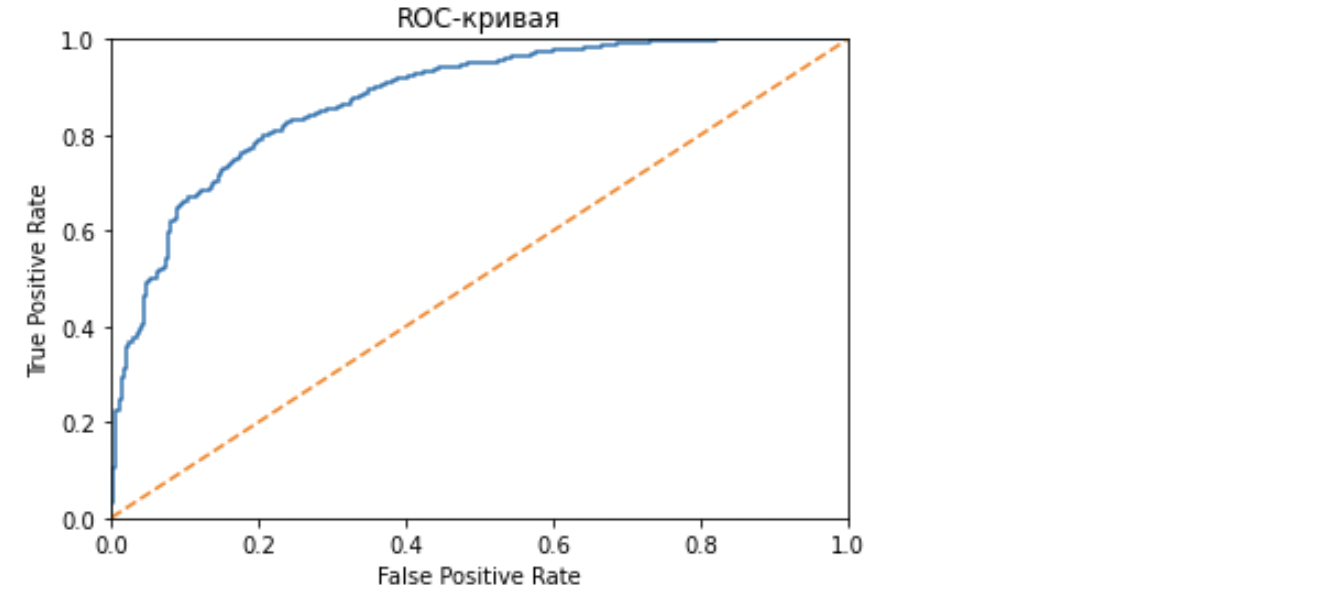
Также посторили матрицу ошибок.
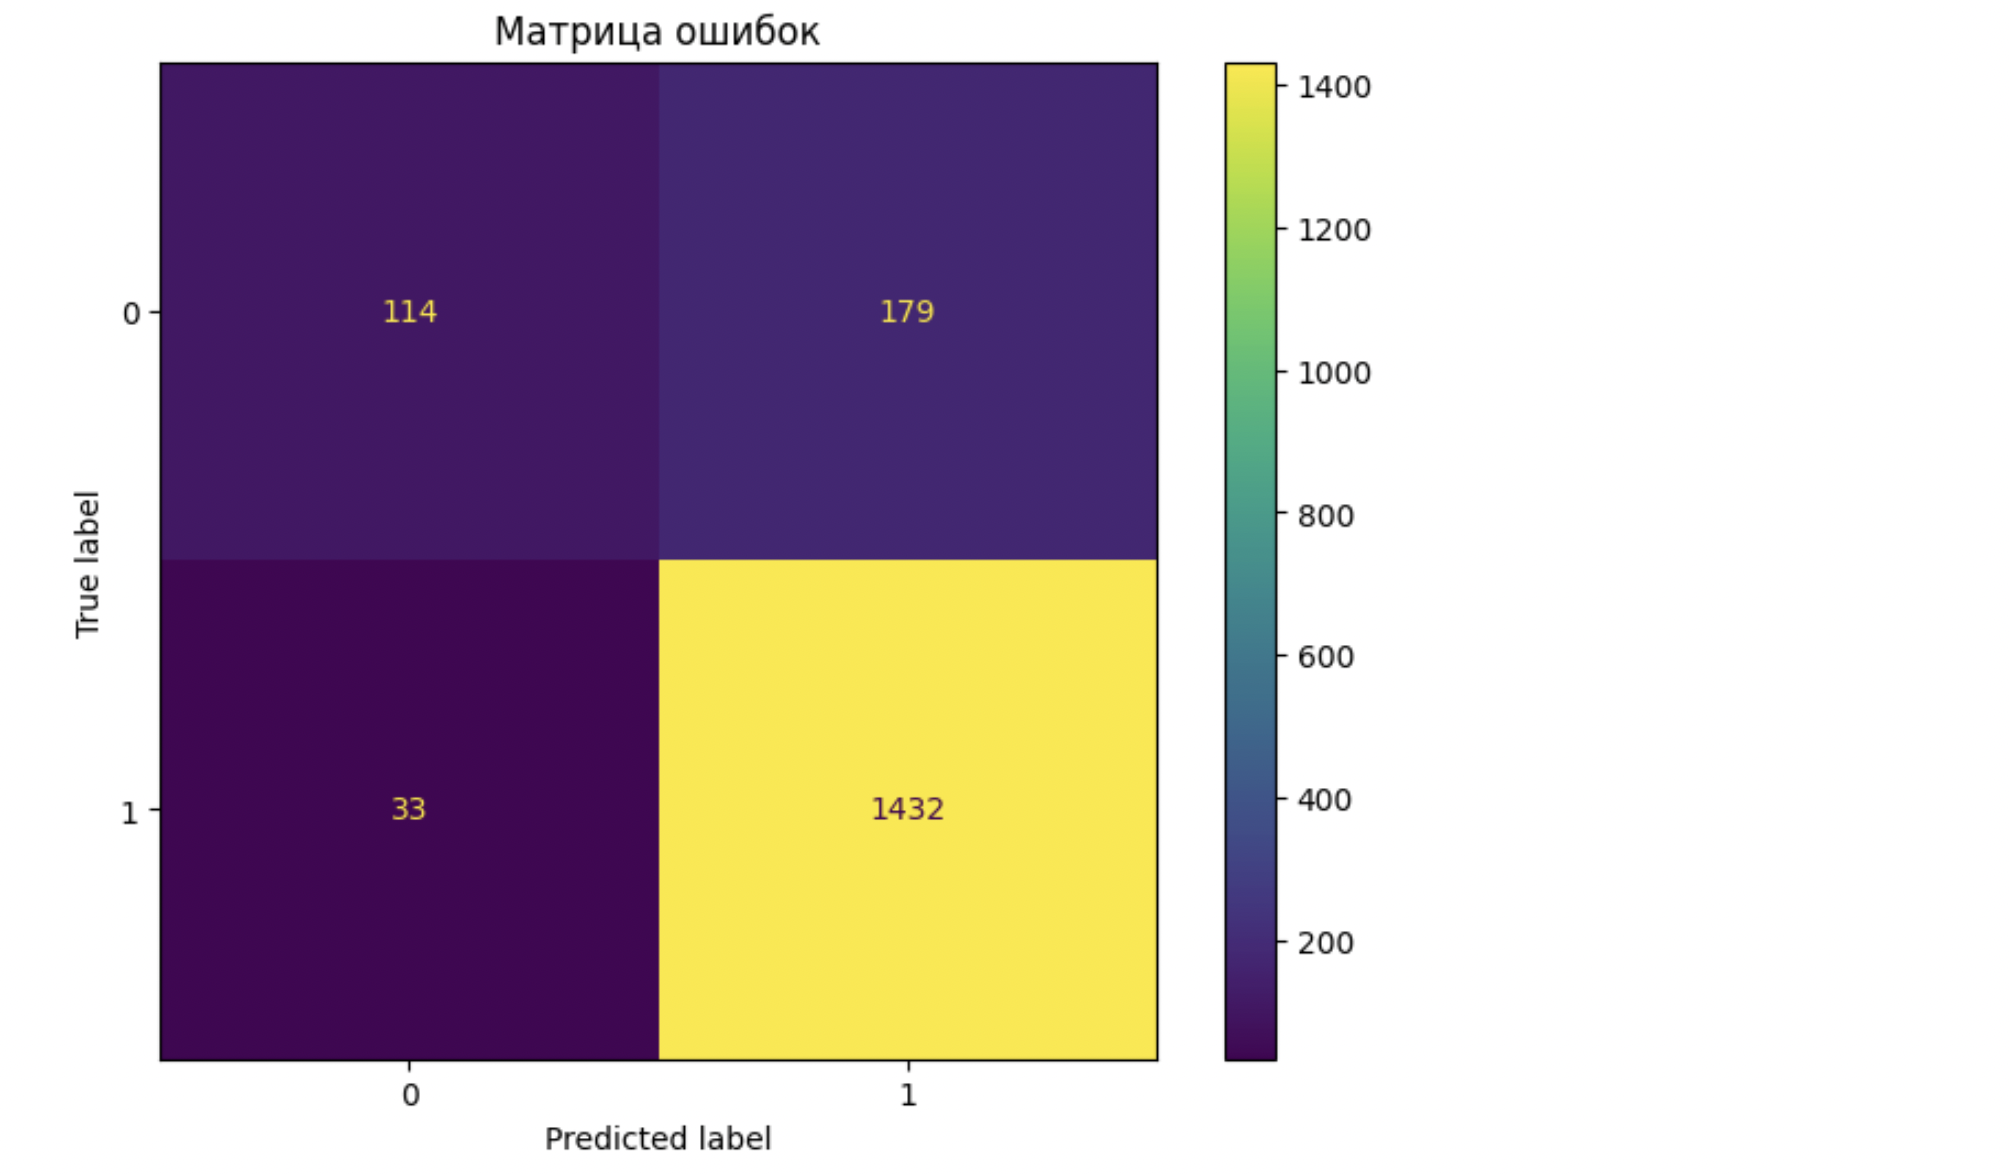
Также из гистограммы важности признаков заметим, что самыми значительными для модели XGBClassifier оказались признаки наличия оюлачного хранилища данных для резервных копий, тип оплаты, наличие мультиканальных линий, период жизни клиента, наличие партнера. Также можем заметить, что все исполльзуемые нами признаки оказались достаточно значимыми для модели.
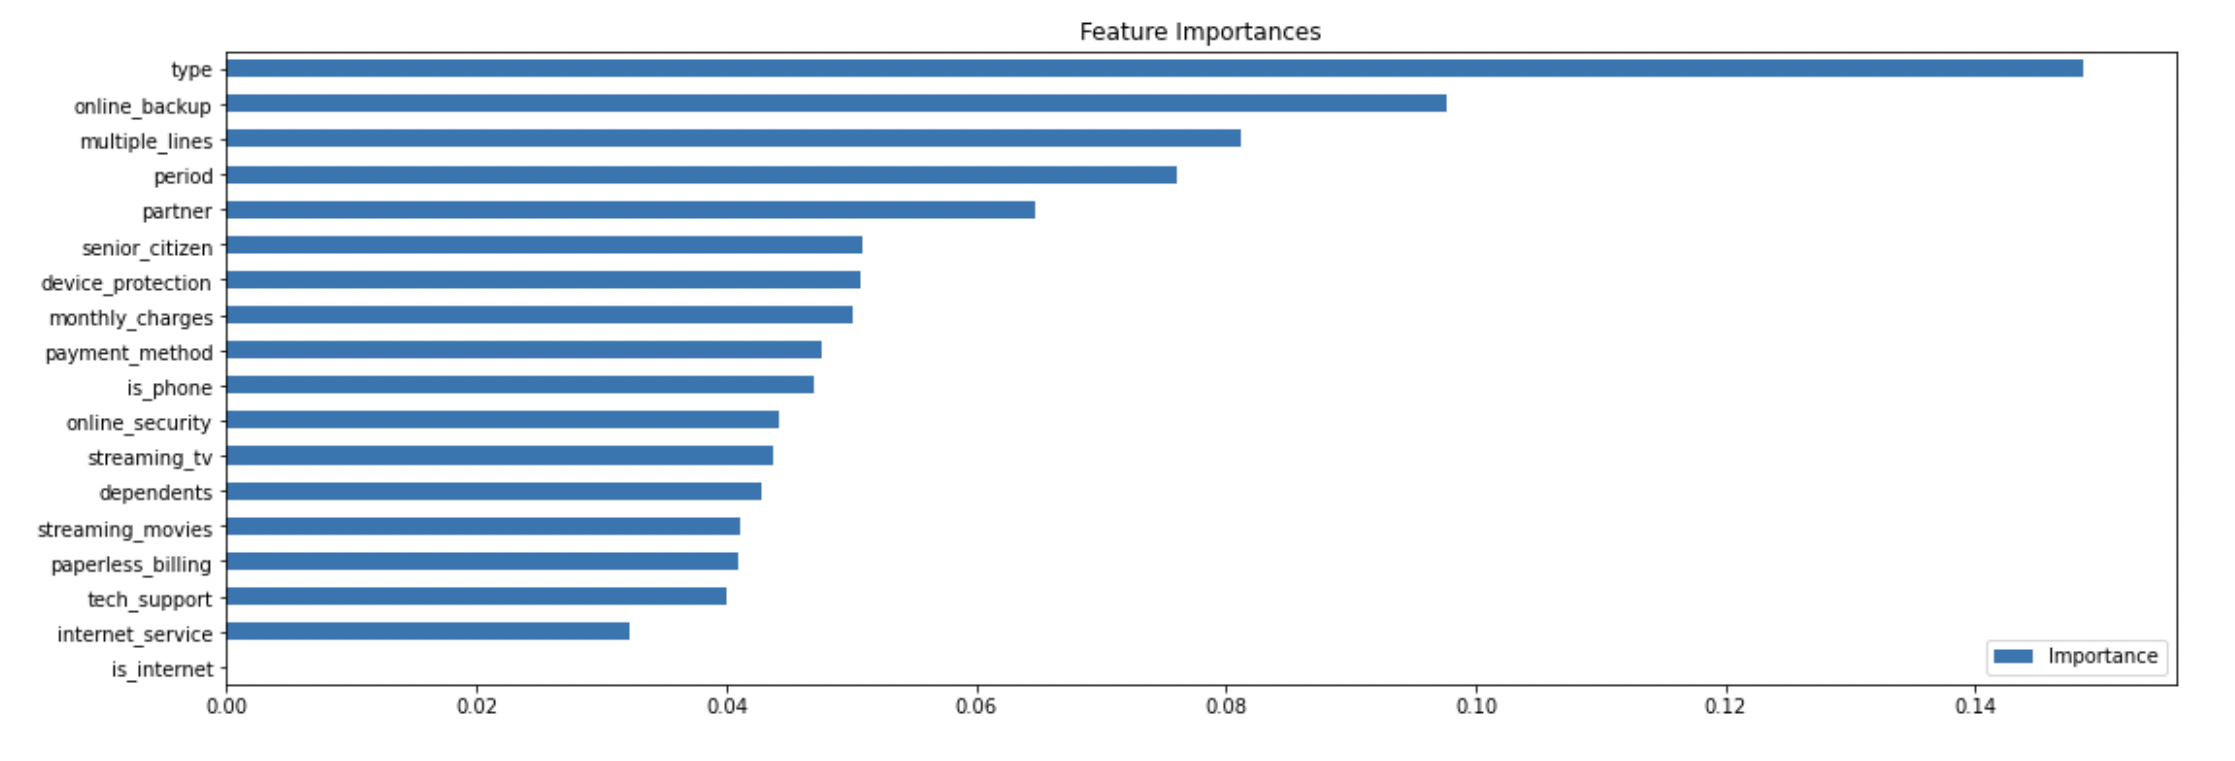